In [1]:
import os
import random
import shutil
import warnings

import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.impute import SimpleImputer, KNNImputer

from library.A_data_collection import make_dataset_for_regression
from library.D_data_analysis import regression
from library.my_functions import pollute_data_mcar, pollute_data_with_constant_feature, \
    pollute_data_mcar_for_each_feature_in_incremental_way, pollute_data_mnar, plot_results, \
    pollute_data_for_distinctness_issues_among_different_features, pollute_data_with_random_noise, \
    pollute_data_with_categorical_variables, pollute_data_with_outliers, \
    pollute_most_important_features, pollute_less_important_features, \
    pollute_data_mcar_for_one_feature, pollute_data_mar  # , pollute_most_important_features

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

SEED = 2023
random.seed(SEED)
np.random.seed(SEED)

# Completeness and Distinctness Issues in Regression

N.B. For each DQ issue you are requested to generate 10 different experiments
1 experiment to correspond to the generation of a plot/with related tables.
For one experiment, the DQ issue assigned to your Group/you must be injected in your data with a different %.
Following, detailed guidelines on which are the expected results for each assigned DQ issue:

Completeness
- consider both Missing Not at Random (MNAR) and Missing Completely at Random (MCAR) missing
value distributions
- Ten experiments with a different distribution of missing values: for example, you can distribute the missing
values uniformly across all columns, or change the percentage of missing values for columns with different
informativeness (changing the default parameter in the data collection). Try to think of a way to simulate
also MNAR distributions!
- For one experiment: varying % of missing values, for example, from 5% to 50% (with an increasing step
of 5%) of injected missing values

Distinctness
- Ten experiments with a different number of polluted features: for example, substituting/polluting a different
number of the original features, or adding more and more features
- For one experiment: varying % of distinctness, from very low distinctness (all values constant) to very
high (all unique values)
- You can also try to combine low distinctness and high-distinctness columns in some experiments


Data Preparation is requested for Completeness.
Select one/more data preparation techniques that we have seen at exercise lectures and implement it/them inside the pipeline.
For Completeness, apply Data Imputation.

## List of algorithms for regression

In [2]:
REGRESSION_ALGORITHMS = [
    "LinearRegressor", "BayesianRidge", "GPRegressor", "SVMRegressor", "KNNRegressor",
    "MLPRegressor"
]

# COMPLETENESS

## Experiment 0. Completeness - Baseline with complete data

In [ ]:
DESCRIPTION = 'Completeness - Baseline with complete data with increasing dataset'
X_LABEL = "Number of samples"

RESULTS_PER_ALGORITHM = []
X_AXIS = [1000 + (n * 10) for n in range(1, 11)]

for algorithm in REGRESSION_ALGORITHMS:
    RESULTS_ALGORITHM = []

    for i in range(len(X_AXIS)):
        # DATA COLLECTION - creating 10 datasets with an increase in the samples
        X, y = make_dataset_for_regression(
            n_samples=1000 + (i * 10), n_features=3, n_informative=3, n_targets=1,
            bias=0.0, effective_rank=None, tail_strength=0.5, noise=0.0, seed=2023
        )

        X = pd.DataFrame(X)

        # DATA ANALYSIS
        RESULTS_ALGORITHM.append(regression(X, y, algorithm, SEED))

    RESULTS_PER_ALGORITHM.append(RESULTS_ALGORITHM)

plot_results(
    x_axis_values=X_AXIS, x_label=X_LABEL, results=RESULTS_PER_ALGORITHM, title=DESCRIPTION,
    algorithms=REGRESSION_ALGORITHMS
)

## Experiment 1. Completeness - MCAR with different low percentages

In [ ]:
DESCRIPTION = 'Completeness - MCAR with different low percentages'
X_LABEL = "Percentage of missing values"

RESULTS_PER_ALGORITHM = []
X_AXIS = [n * 0.025 for n in range(1, 11)]

for algorithm in REGRESSION_ALGORITHMS:
    RESULTS_ALGORITHM = []

    for i in range(len(X_AXIS)):
        # DATA COLLECTION - creating 10 datasets with an increase in the samples
        X, y = make_dataset_for_regression(
            n_samples=1000, n_features=3, n_informative=3, n_targets=1,
            bias=0.0, effective_rank=None, tail_strength=0.5, noise=0.0, seed=2023
        )

        X = pd.DataFrame(X)

        pollute_data_mcar(X, percent_incomplete=X_AXIS[i])

        # DATA ANALYSIS
        RESULTS_ALGORITHM.append(regression(X, y, algorithm, SEED))

    RESULTS_PER_ALGORITHM.append(RESULTS_ALGORITHM)

plot_results(
    x_axis_values=X_AXIS, x_label=X_LABEL, results=RESULTS_PER_ALGORITHM, title=DESCRIPTION,
    algorithms=REGRESSION_ALGORITHMS
)

In [ ]:
RESULTS_PER_ALGORITHM = []

SI = SimpleImputer(missing_values=np.NaN, strategy="median")  # as fillna - mean

for algorithm in REGRESSION_ALGORITHMS:  # FIRST CYCLE ON THE ALGORITHMS
    RESULTS_ALGORITHM = []

    for i in range(len(X_AXIS)):
        # DATA COLLECTION - creating 10 datasets with an increase in the samples
        X, y = make_dataset_for_regression(
            n_samples=1000, n_features=3, n_informative=3, n_targets=1, bias=0.0,
            effective_rank=None, tail_strength=0.5, noise=0.0, seed=2023
        )
        X = pd.DataFrame(X)

        pollute_data_mcar(X, percent_incomplete=X_AXIS[i])
        X_CLEAN = SI.fit_transform(X)

        # DATA ANALYSIS
        RESULTS_ALGORITHM.append(regression(X_CLEAN, y, algorithm, SEED))

    RESULTS_PER_ALGORITHM.append(RESULTS_ALGORITHM)

plot_results(
    x_axis_values=X_AXIS, x_label=X_LABEL, results=RESULTS_PER_ALGORITHM, title=DESCRIPTION,
    algorithms=REGRESSION_ALGORITHMS, cleaned_data=True
)

## Experiment 2. Completeness - MCAR with different high percentages

In [ ]:
DESCRIPTION = 'Completeness - MCAR with different high percentages'
X_LABEL = "Percentage of missing values"

RESULTS_PER_ALGORITHM = []
X_AXIS = [n * 0.025 for n in range(11, 21)]

for algorithm in REGRESSION_ALGORITHMS:
    RESULTS_ALGORITHM = []

    for i in range(len(X_AXIS)):
        # DATA COLLECTION - creating 10 datasets with an increase in the samples
        X, y = make_dataset_for_regression(
            n_samples=1000, n_features=3, n_informative=3, n_targets=1,
            bias=0.0, effective_rank=None, tail_strength=0.5, noise=0.0, seed=2023
        )

        X = pd.DataFrame(X)

        pollute_data_mcar(X, percent_incomplete=X_AXIS[i])

        # DATA ANALYSIS
        RESULTS_ALGORITHM.append(regression(X, y, algorithm, SEED))

    RESULTS_PER_ALGORITHM.append(RESULTS_ALGORITHM)

plot_results(
    x_axis_values=X_AXIS, x_label=X_LABEL, results=RESULTS_PER_ALGORITHM, title=DESCRIPTION,
    algorithms=REGRESSION_ALGORITHMS
)

In [ ]:
RESULTS_PER_ALGORITHM = []

SI = SimpleImputer(missing_values=np.NaN, strategy="median")  # as fillna - mean

for algorithm in REGRESSION_ALGORITHMS:  # FIRST CYCLE ON THE ALGORITHMS
    RESULTS_ALGORITHM = []

    for i in range(len(X_AXIS)):
        # DATA COLLECTION - creating 10 datasets with an increase in the samples
        X, y = make_dataset_for_regression(
            n_samples=1000, n_features=3, n_informative=3, n_targets=1, bias=0.0,
            effective_rank=None, tail_strength=0.5, noise=0.0, seed=2023
        )
        X = pd.DataFrame(X)

        pollute_data_mcar(X, percent_incomplete=X_AXIS[i])
        X_CLEAN = SI.fit_transform(X)

        # DATA ANALYSIS
        RESULTS_ALGORITHM.append(regression(X_CLEAN, y, algorithm, SEED))

    RESULTS_PER_ALGORITHM.append(RESULTS_ALGORITHM)

plot_results(
    x_axis_values=X_AXIS, x_label=X_LABEL, results=RESULTS_PER_ALGORITHM, title=DESCRIPTION,
    algorithms=REGRESSION_ALGORITHMS, cleaned_data=True
)

## Experiment 3. Completeness - fixed MCAR for different features in the dataset with different imputations

Training for LinearRegressor...
Training for LinearRegressor...
Training for LinearRegressor...
Training for LinearRegressor...
Training for LinearRegressor...
Training for LinearRegressor...
Training for LinearRegressor...
Training for LinearRegressor...
Training for LinearRegressor...
Training for LinearRegressor...
Training for BayesianRidge...
Training for BayesianRidge...
Training for BayesianRidge...
Training for BayesianRidge...
Training for BayesianRidge...
Training for BayesianRidge...
Training for BayesianRidge...
Training for BayesianRidge...
Training for BayesianRidge...
Training for BayesianRidge...
Training for GPRegressor...
Training for GPRegressor...
Training for GPRegressor...
Training for GPRegressor...
Training for GPRegressor...
Training for GPRegressor...
Training for GPRegressor...
Training for GPRegressor...
Training for GPRegressor...
Training for GPRegressor...
Training for SVMRegressor...
Training for SVMRegressor...
Training for SVMRegressor...
Training for 

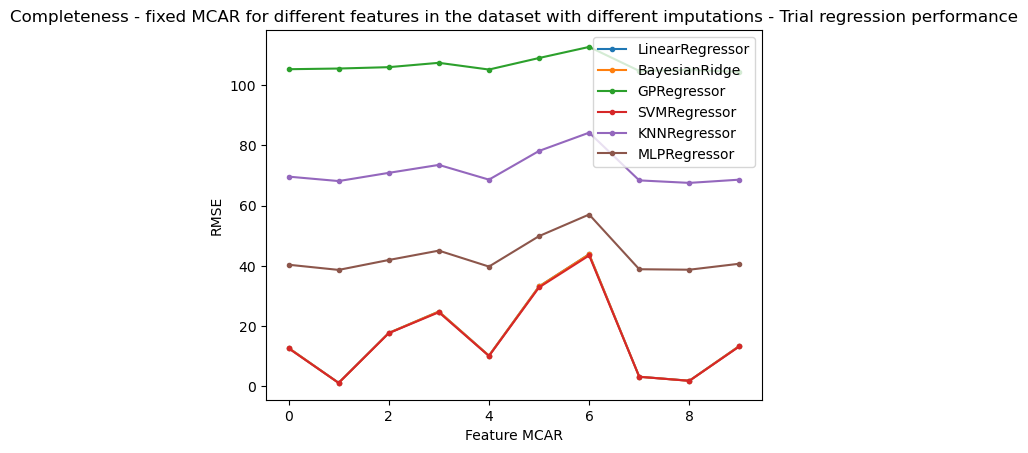

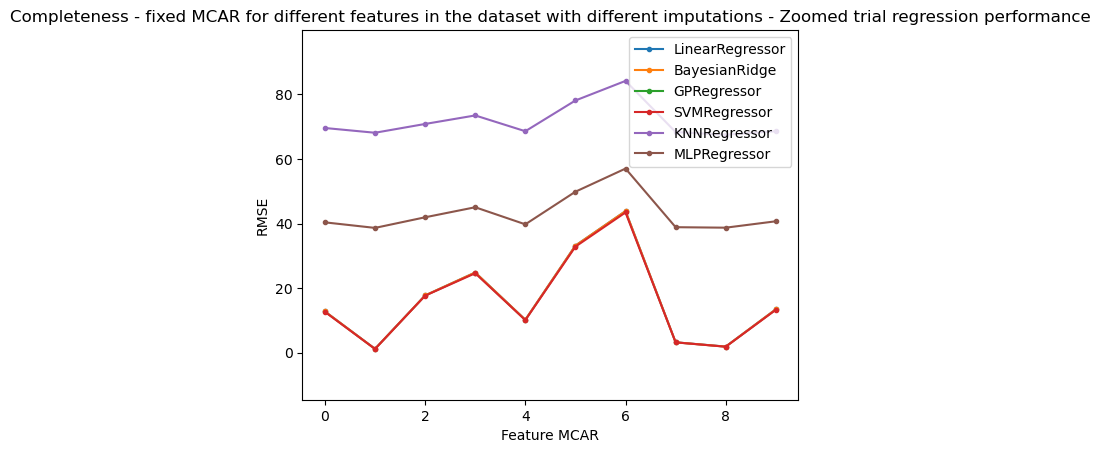

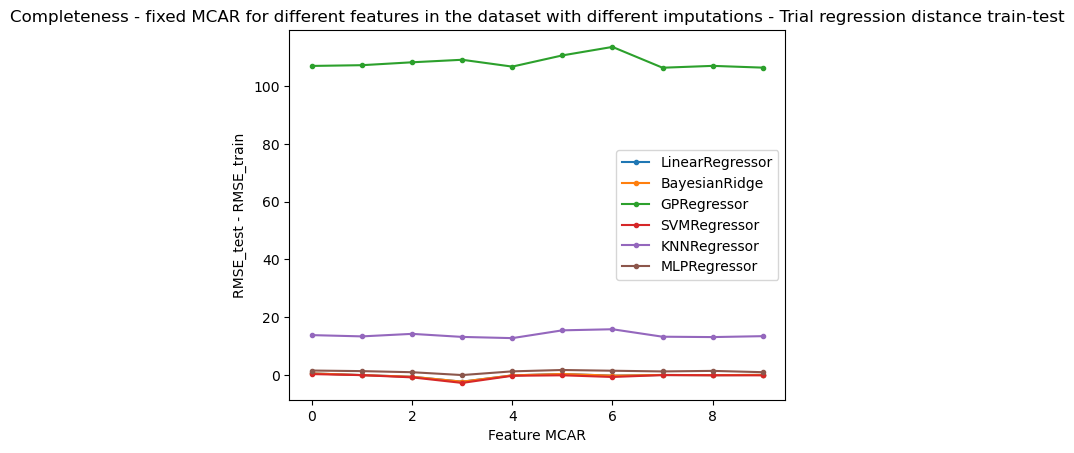

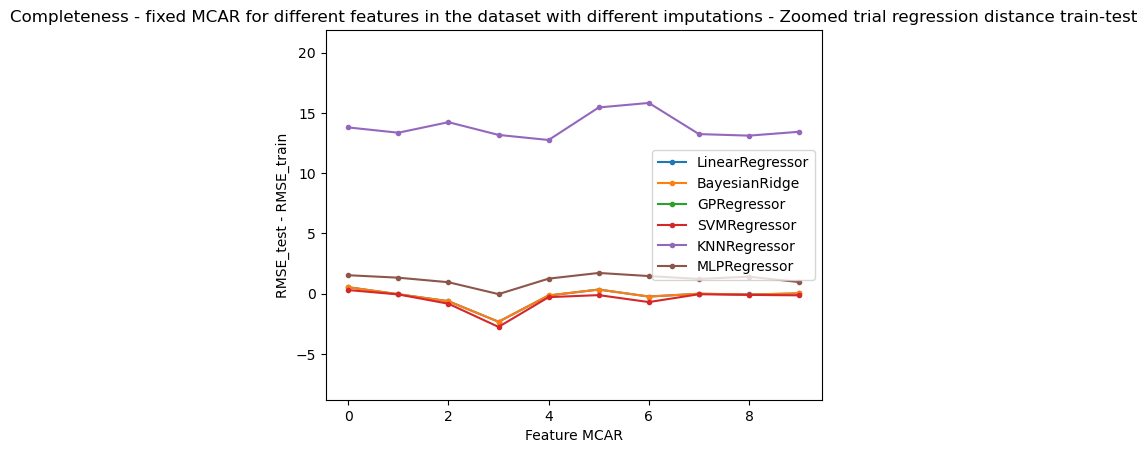

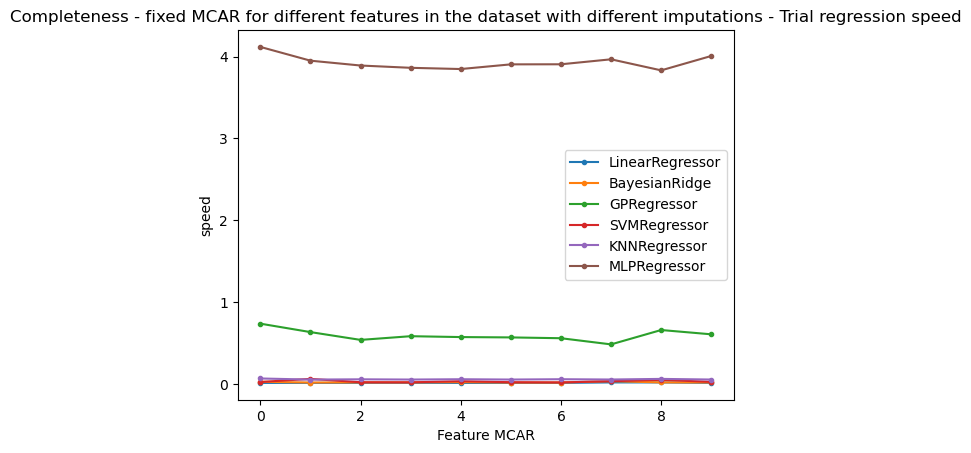

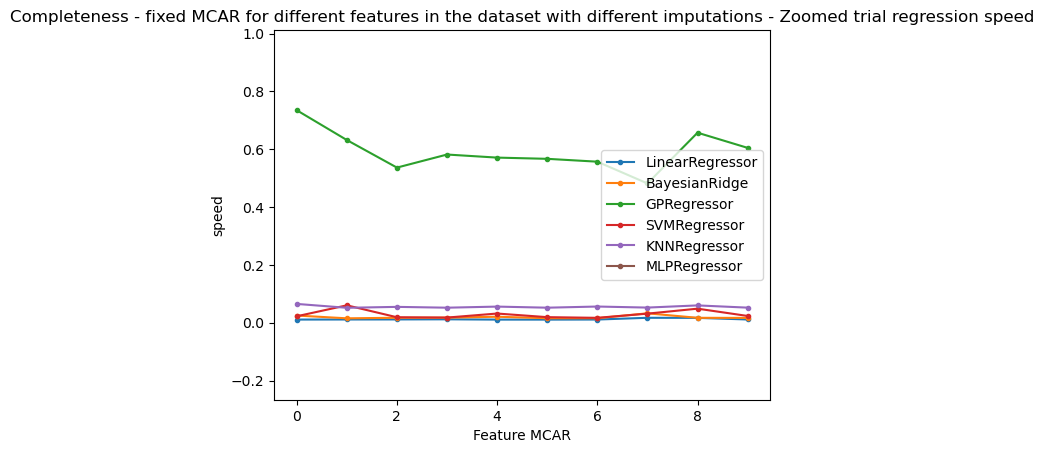

In [5]:
DESCRIPTION = 'Completeness - fixed MCAR for different features in the dataset with different imputations'
X_LABEL = "Feature MCAR"

RESULTS_PER_ALGORITHM = []
X_AXIS = range(0, 10)

for algorithm in REGRESSION_ALGORITHMS:
    RESULTS_ALGORITHM = []

    for i in range(len(X_AXIS)):
        # DATA COLLECTION - creating 10 datasets with an increase in the samples
        X, y = make_dataset_for_regression(
            n_samples=1000, n_features=10, n_informative=10, n_targets=1,
            bias=0.0, effective_rank=None, tail_strength=0.5, noise=0.0, seed=2023
        )

        X = pd.DataFrame(X)

        pollute_data_mcar_for_one_feature(X, i, percent_incomplete=0.2)

        # DATA ANALYSIS
        RESULTS_ALGORITHM.append(regression(X, y, algorithm, SEED))

    RESULTS_PER_ALGORITHM.append(RESULTS_ALGORITHM)

plot_results(
    x_axis_values=X_AXIS, x_label=X_LABEL, results=RESULTS_PER_ALGORITHM, title=DESCRIPTION,
    algorithms=REGRESSION_ALGORITHMS
)

In [ ]:
DESCRIPTION = 'Completeness - fixed MCAR for different features imputing the median'
RESULTS_PER_ALGORITHM = []

SI = SimpleImputer(missing_values=np.NaN, strategy="median")  # as fillna - mean

for algorithm in REGRESSION_ALGORITHMS:  # FIRST CYCLE ON THE ALGORITHMS
    RESULTS_ALGORITHM = []

    for i in range(len(X_AXIS)):
        # DATA COLLECTION - creating 10 datasets with an increase in the samples
        X, y = make_dataset_for_regression(
            n_samples=1000, n_features=10, n_informative=10, n_targets=1, bias=0.0,
            effective_rank=None, tail_strength=0.5, noise=0.0, seed=2023
        )
        
        X = pd.DataFrame(X)

        pollute_data_mcar_for_one_feature(X, i, percent_incomplete=0.2)
        X_CLEAN = SI.fit_transform(X)

        # DATA ANALYSIS
        RESULTS_ALGORITHM.append(regression(X_CLEAN, y, algorithm, SEED))

    RESULTS_PER_ALGORITHM.append(RESULTS_ALGORITHM)

plot_results(
    x_axis_values=X_AXIS, x_label=X_LABEL, results=RESULTS_PER_ALGORITHM, title=DESCRIPTION,
    algorithms=REGRESSION_ALGORITHMS, cleaned_data=True
)

In [ ]:
DESCRIPTION = 'Completeness - fixed MCAR for different features imputing the most frequent value'
RESULTS_PER_ALGORITHM = []

SI = SimpleImputer(missing_values=np.NaN, strategy="most_frequent")  # as fillna - mean

for algorithm in REGRESSION_ALGORITHMS:  # FIRST CYCLE ON THE ALGORITHMS
    RESULTS_ALGORITHM = []

    for i in range(len(X_AXIS)):
        # DATA COLLECTION - creating 10 datasets with an increase in the samples
        X, y = make_dataset_for_regression(
            n_samples=1000, n_features=10, n_informative=10, n_targets=1, bias=0.0,
            effective_rank=None, tail_strength=0.5, noise=0.0, seed=2023
        )

        X = pd.DataFrame(X)

        pollute_data_mcar_for_one_feature(X, i, percent_incomplete=0.2)
        X_CLEAN = SI.fit_transform(X)

        # DATA ANALYSIS
        RESULTS_ALGORITHM.append(regression(X_CLEAN, y, algorithm, SEED))

    RESULTS_PER_ALGORITHM.append(RESULTS_ALGORITHM)

plot_results(
    x_axis_values=X_AXIS, x_label=X_LABEL, results=RESULTS_PER_ALGORITHM, title=DESCRIPTION,
    algorithms=REGRESSION_ALGORITHMS, cleaned_data=True
)

In [ ]:
DESCRIPTION = 'Completeness - fixed MCAR for different features imputing the mean'
RESULTS_PER_ALGORITHM = []

SI = SimpleImputer(missing_values=np.NaN, strategy="mean")  # as fillna - mean

for algorithm in REGRESSION_ALGORITHMS:  # FIRST CYCLE ON THE ALGORITHMS
    RESULTS_ALGORITHM = []

    for i in range(len(X_AXIS)):
        # DATA COLLECTION - creating 10 datasets with an increase in the samples
        X, y = make_dataset_for_regression(
            n_samples=1000, n_features=10, n_informative=10, n_targets=1, bias=0.0,
            effective_rank=None, tail_strength=0.5, noise=0.0, seed=2023
        )

        X = pd.DataFrame(X)

        pollute_data_mcar_for_one_feature(X, i, percent_incomplete=0.2)
        X_CLEAN = SI.fit_transform(X)

        # DATA ANALYSIS
        RESULTS_ALGORITHM.append(regression(X_CLEAN, y, algorithm, SEED))

    RESULTS_PER_ALGORITHM.append(RESULTS_ALGORITHM)

plot_results(
    x_axis_values=X_AXIS, x_label=X_LABEL, results=RESULTS_PER_ALGORITHM, title=DESCRIPTION,
    algorithms=REGRESSION_ALGORITHMS, cleaned_data=True
)

Training for LinearRegressor...
Training for LinearRegressor...
Training for LinearRegressor...
Training for LinearRegressor...
Training for LinearRegressor...
Training for LinearRegressor...
Training for LinearRegressor...
Training for LinearRegressor...
Training for LinearRegressor...
Training for LinearRegressor...
Training for BayesianRidge...
Training for BayesianRidge...
Training for BayesianRidge...
Training for BayesianRidge...
Training for BayesianRidge...
Training for BayesianRidge...
Training for BayesianRidge...
Training for BayesianRidge...
Training for BayesianRidge...
Training for BayesianRidge...
Training for GPRegressor...
Training for GPRegressor...
Training for GPRegressor...
Training for GPRegressor...
Training for GPRegressor...
Training for GPRegressor...
Training for GPRegressor...
Training for GPRegressor...
Training for GPRegressor...
Training for GPRegressor...
Training for SVMRegressor...
Training for SVMRegressor...
Training for SVMRegressor...
Training for 

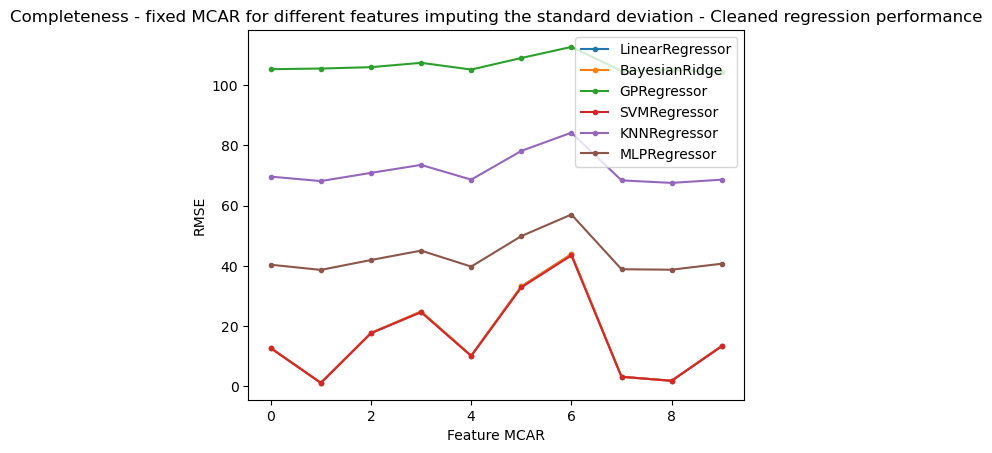

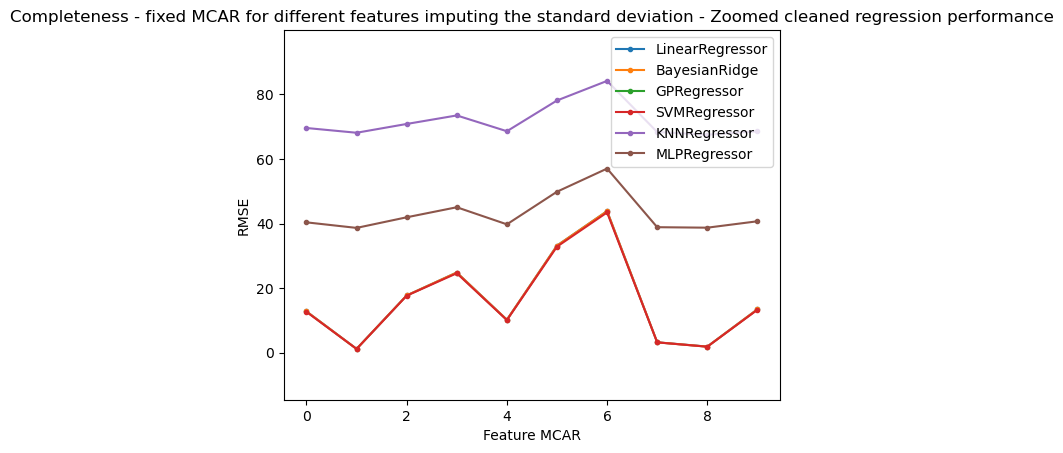

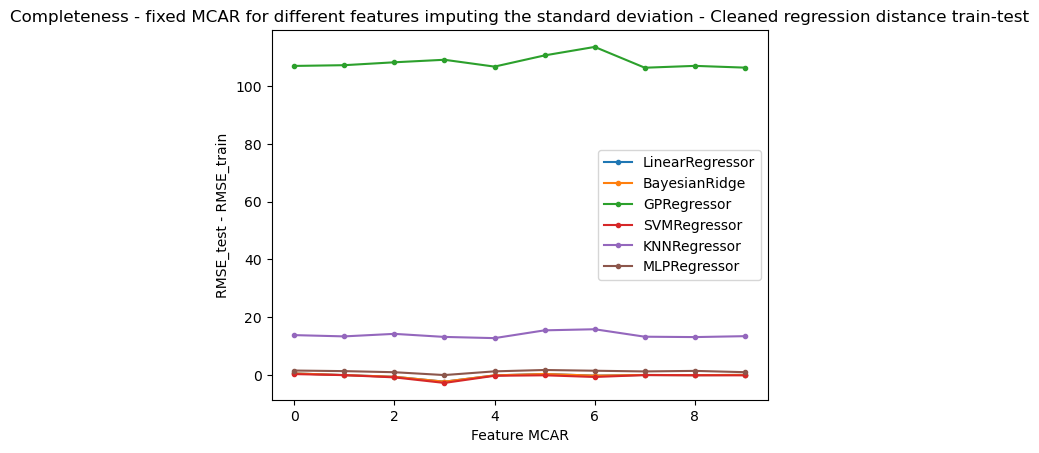

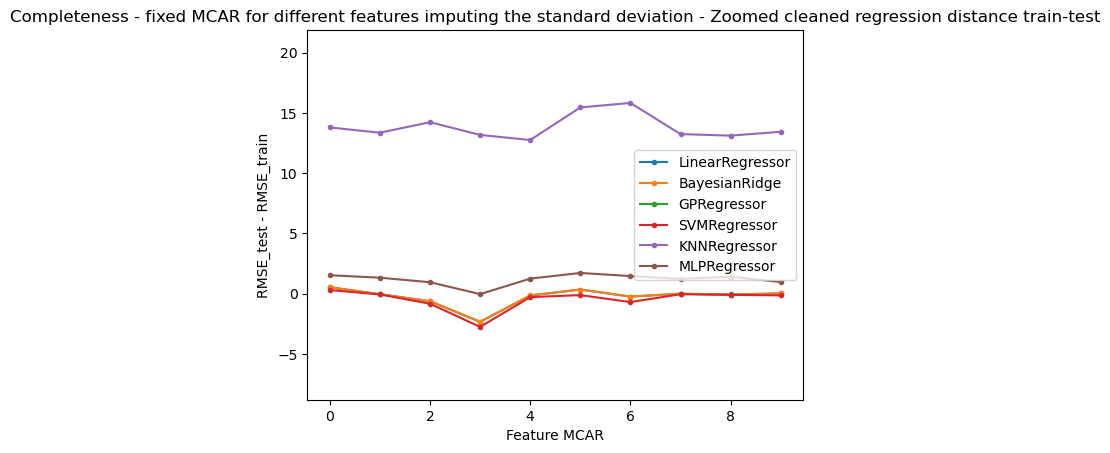

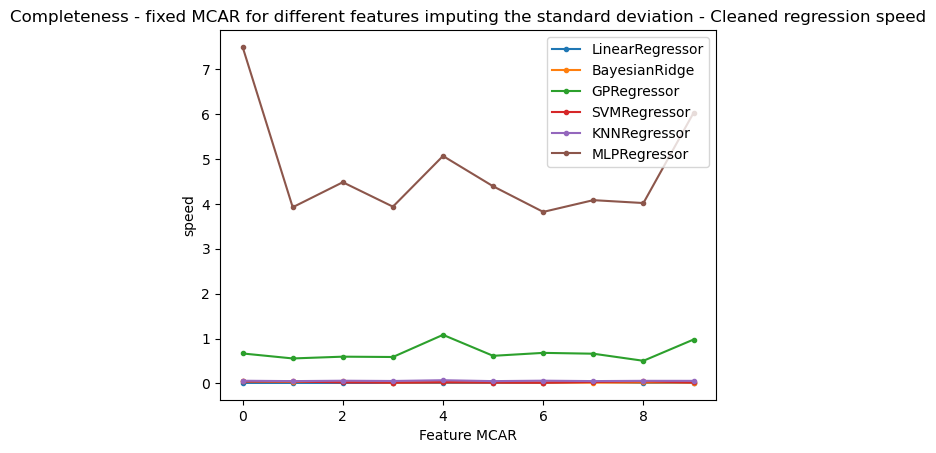

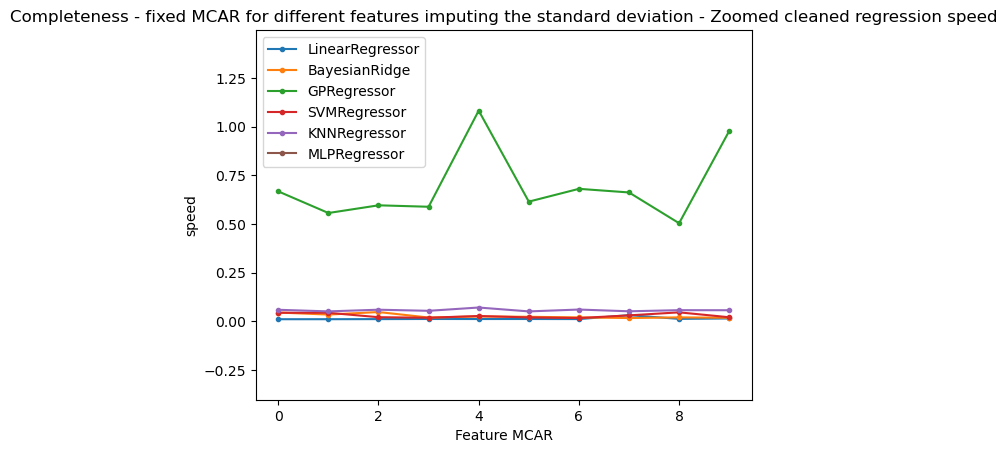

In [6]:
DESCRIPTION = 'Completeness - fixed MCAR for different features imputing the standard deviation'
RESULTS_PER_ALGORITHM = []

for algorithm in REGRESSION_ALGORITHMS:  # FIRST CYCLE ON THE ALGORITHMS
    RESULTS_ALGORITHM = []

    for i in range(len(X_AXIS)):
        # DATA COLLECTION - creating 10 datasets with an increase in the samples
        X, y = make_dataset_for_regression(
            n_samples=1000, n_features=10, n_informative=10, n_targets=1, bias=0.0,
            effective_rank=None, tail_strength=0.5, noise=0.0, seed=2023
        )

        X = pd.DataFrame(X)

        pollute_data_mcar_for_one_feature(X, i, percent_incomplete=0.2)
        
        X_CLEAN = X.copy()
        X_CLEAN[i].fillna(X_CLEAN[i].std())

        # DATA ANALYSIS
        RESULTS_ALGORITHM.append(regression(X_CLEAN, y, algorithm, SEED))

    RESULTS_PER_ALGORITHM.append(RESULTS_ALGORITHM)

plot_results(
    x_axis_values=X_AXIS, x_label=X_LABEL, results=RESULTS_PER_ALGORITHM, title=DESCRIPTION,
    algorithms=REGRESSION_ALGORITHMS, cleaned_data=True
)

Training for LinearRegressor...
Training for LinearRegressor...
Training for LinearRegressor...
Training for LinearRegressor...
Training for LinearRegressor...
Training for LinearRegressor...
Training for LinearRegressor...
Training for LinearRegressor...
Training for LinearRegressor...
Training for LinearRegressor...
Training for BayesianRidge...
Training for BayesianRidge...
Training for BayesianRidge...
Training for BayesianRidge...
Training for BayesianRidge...
Training for BayesianRidge...
Training for BayesianRidge...
Training for BayesianRidge...
Training for BayesianRidge...
Training for BayesianRidge...
Training for GPRegressor...
Training for GPRegressor...
Training for GPRegressor...
Training for GPRegressor...
Training for GPRegressor...
Training for GPRegressor...
Training for GPRegressor...
Training for GPRegressor...
Training for GPRegressor...
Training for GPRegressor...
Training for SVMRegressor...
Training for SVMRegressor...
Training for SVMRegressor...
Training for 

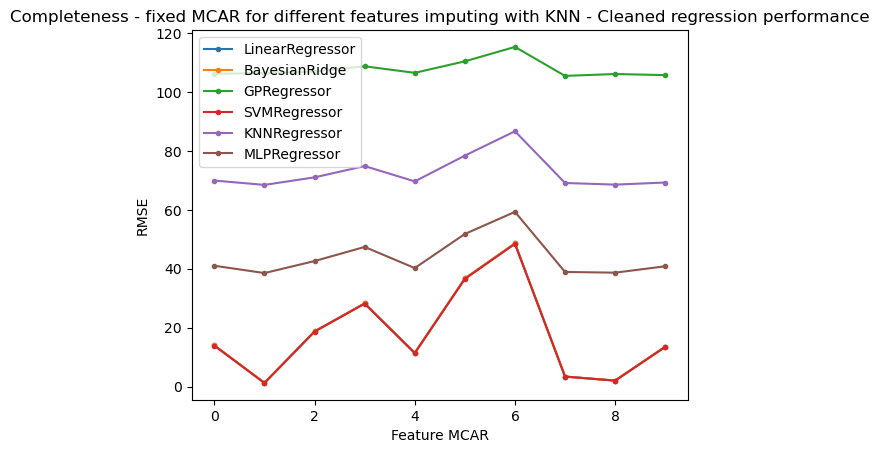

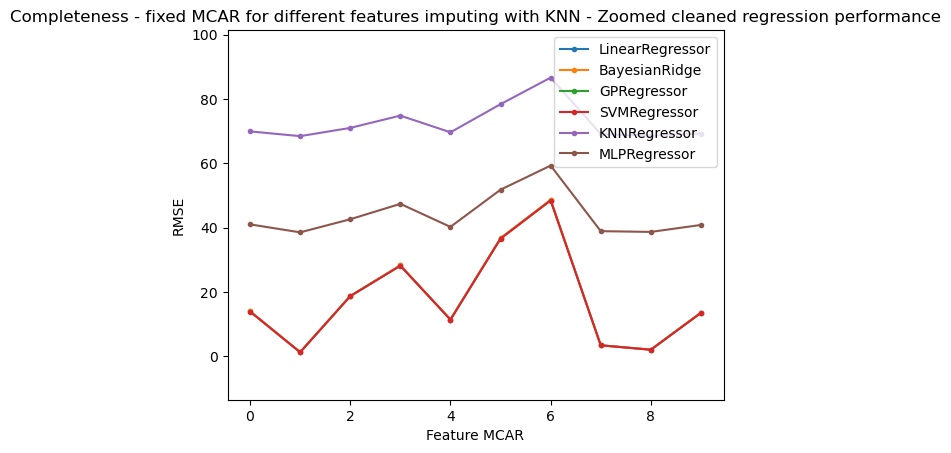

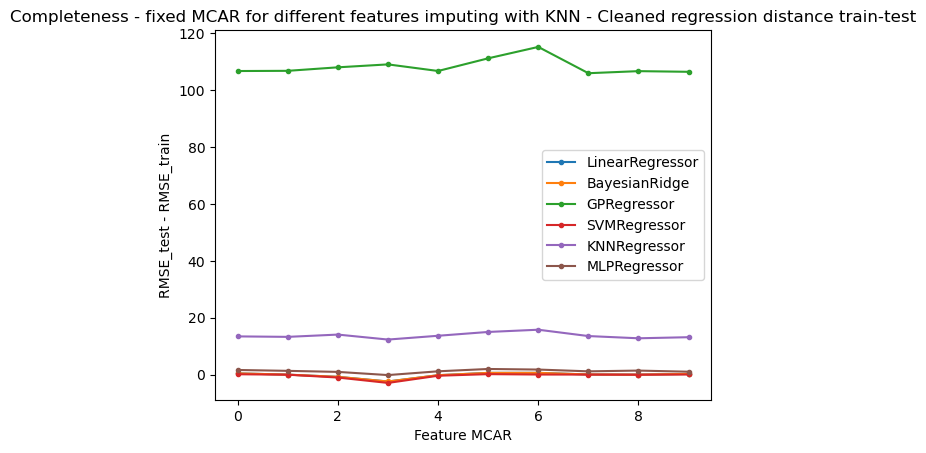

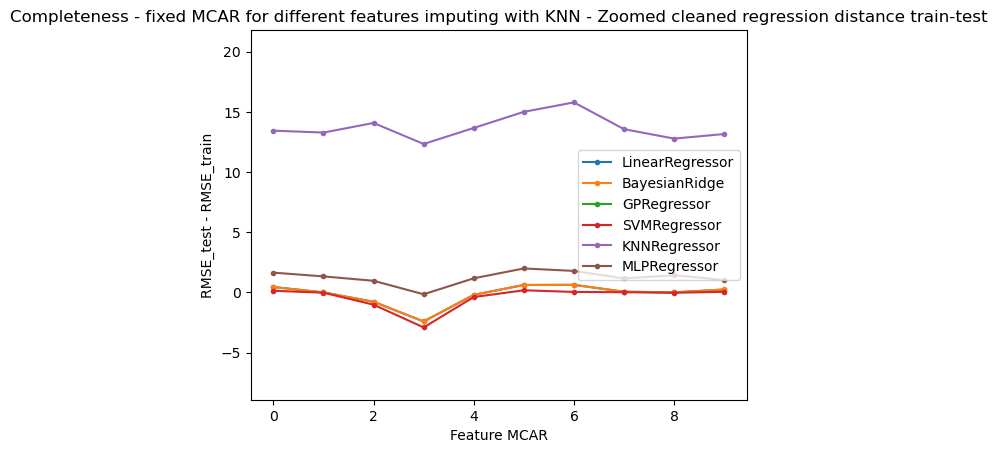

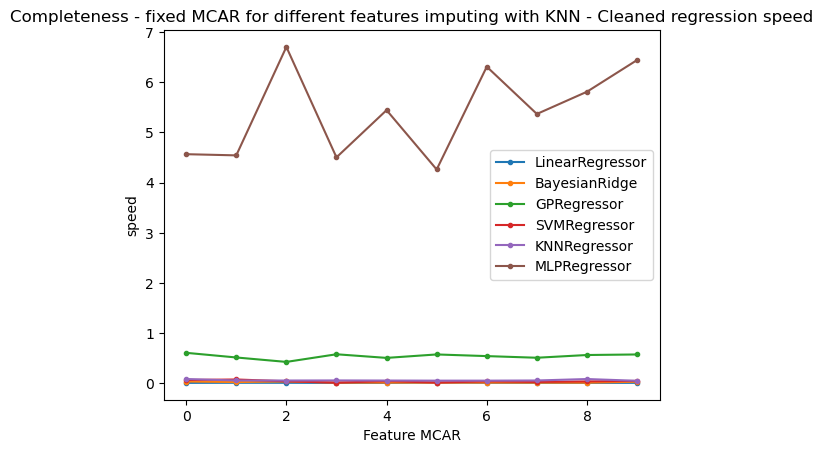

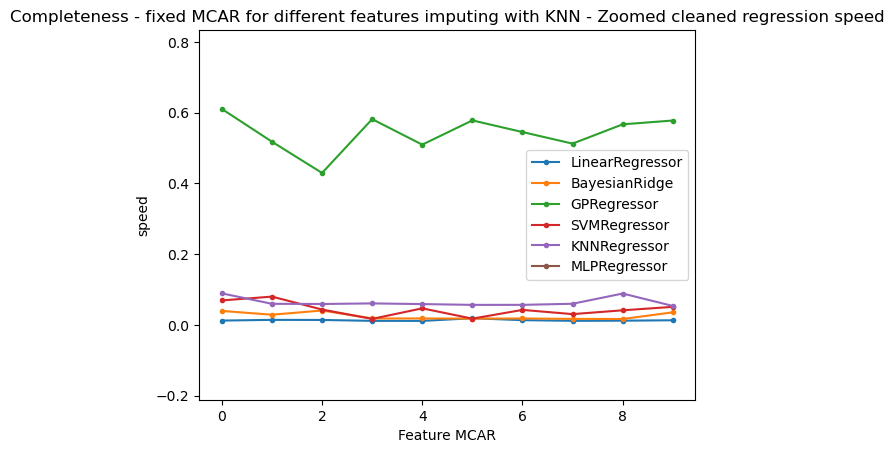

In [7]:
DESCRIPTION = 'Completeness - fixed MCAR for different features imputing with KNN'
RESULTS_PER_ALGORITHM = []

IMPUTER = KNNImputer(n_neighbors=5)

for algorithm in REGRESSION_ALGORITHMS:  # FIRST CYCLE ON THE ALGORITHMS
    RESULTS_ALGORITHM = []

    for i in range(len(X_AXIS)):
        # DATA COLLECTION - creating 10 datasets with an increase in the samples
        X, y = make_dataset_for_regression(
            n_samples=1000, n_features=10, n_informative=10, n_targets=1, bias=0.0,
            effective_rank=None, tail_strength=0.5, noise=0.0, seed=2023
        )

        X = pd.DataFrame(X)

        pollute_data_mcar_for_one_feature(X, i, percent_incomplete=0.2)

        df = X.copy()
        
        df_knn = pd.DataFrame(IMPUTER.fit_transform(df))
        df_knn.columns = df.columns #Retransforming it in a DF with the same columns
        X_CLEAN = X.copy()
        X_CLEAN[i] = df_knn[i]

        # DATA ANALYSIS
        RESULTS_ALGORITHM.append(regression(X_CLEAN, y, algorithm, SEED))

    RESULTS_PER_ALGORITHM.append(RESULTS_ALGORITHM)

plot_results(
    x_axis_values=X_AXIS, x_label=X_LABEL, results=RESULTS_PER_ALGORITHM, title=DESCRIPTION,
    algorithms=REGRESSION_ALGORITHMS, cleaned_data=True
)

Training for LinearRegressor...
Training for LinearRegressor...
Training for LinearRegressor...
Training for LinearRegressor...
Training for LinearRegressor...
Training for LinearRegressor...
Training for LinearRegressor...
Training for LinearRegressor...
Training for LinearRegressor...
Training for LinearRegressor...
Training for BayesianRidge...
Training for BayesianRidge...
Training for BayesianRidge...
Training for BayesianRidge...
Training for BayesianRidge...
Training for BayesianRidge...
Training for BayesianRidge...
Training for BayesianRidge...
Training for BayesianRidge...
Training for BayesianRidge...
Training for GPRegressor...
Training for GPRegressor...
Training for GPRegressor...
Training for GPRegressor...
Training for GPRegressor...
Training for GPRegressor...
Training for GPRegressor...
Training for GPRegressor...
Training for GPRegressor...
Training for GPRegressor...
Training for SVMRegressor...
Training for SVMRegressor...
Training for SVMRegressor...
Training for 

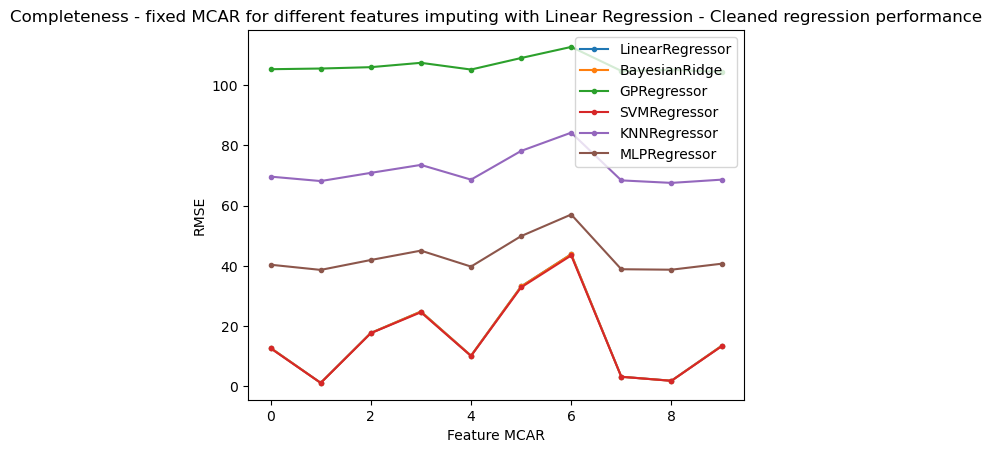

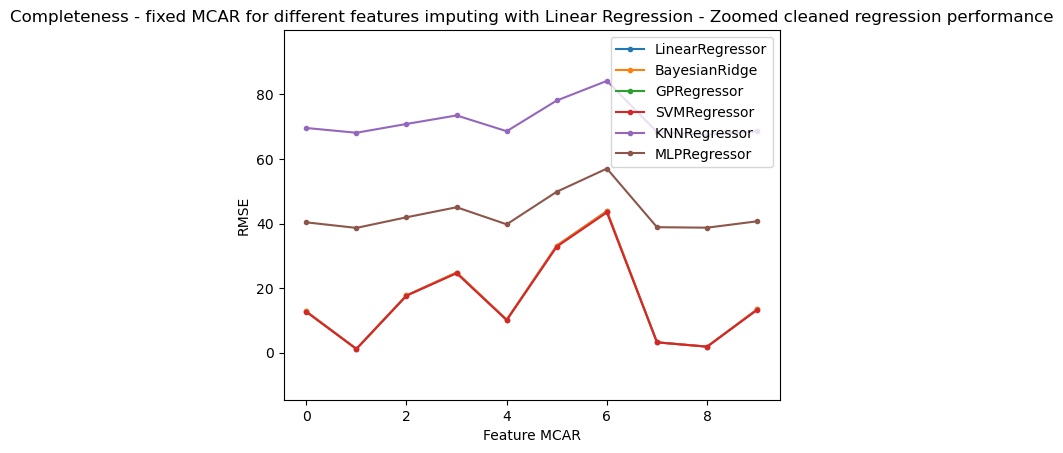

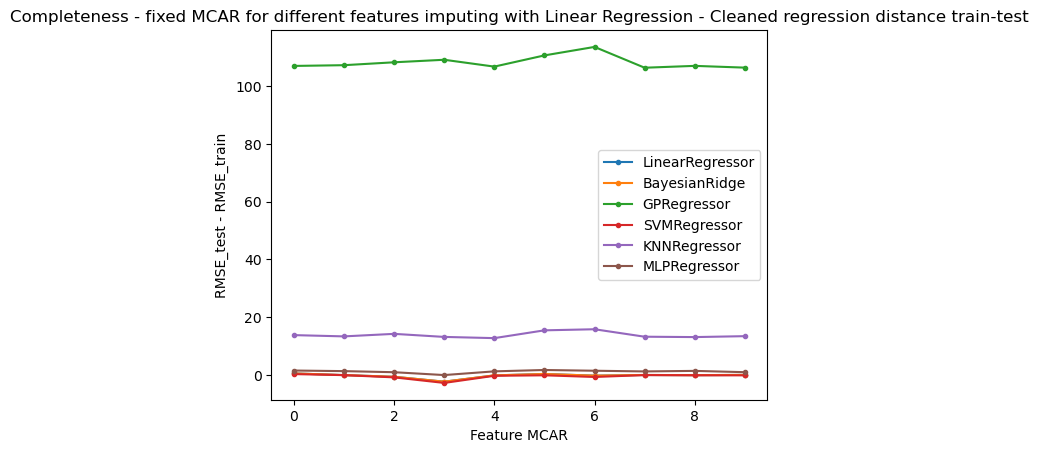

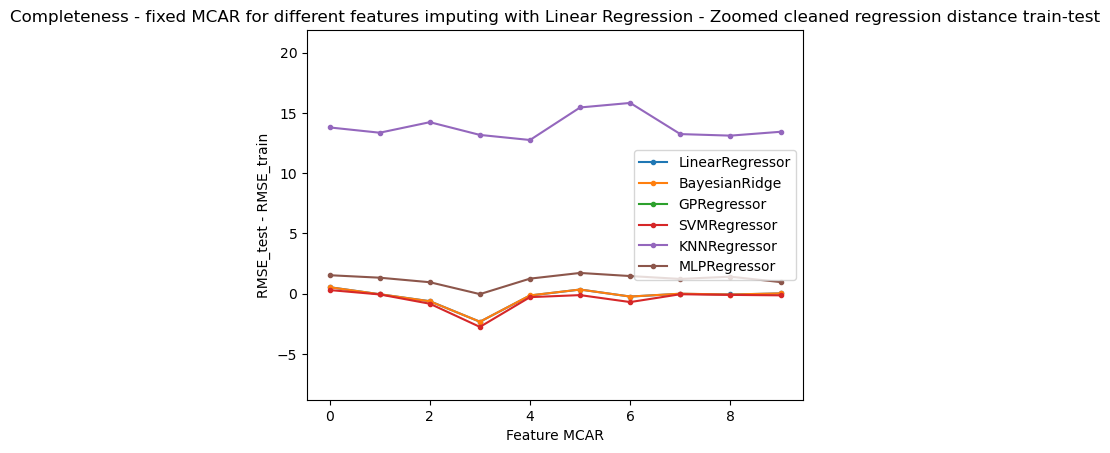

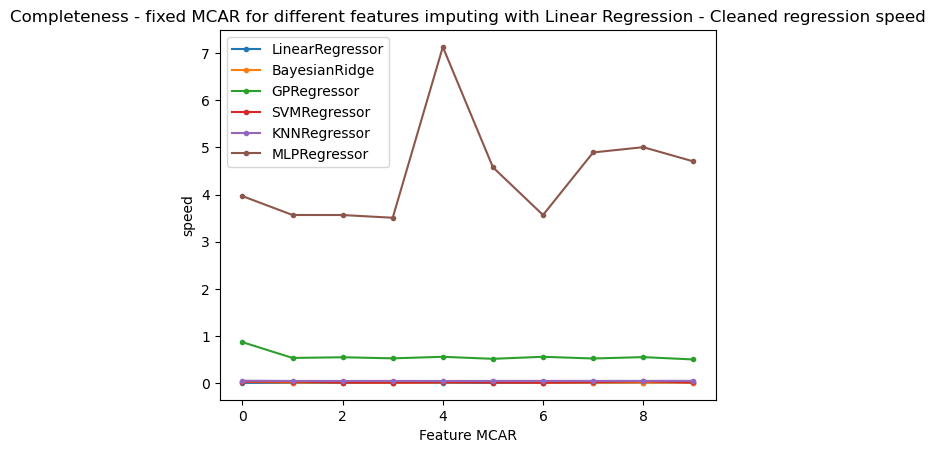

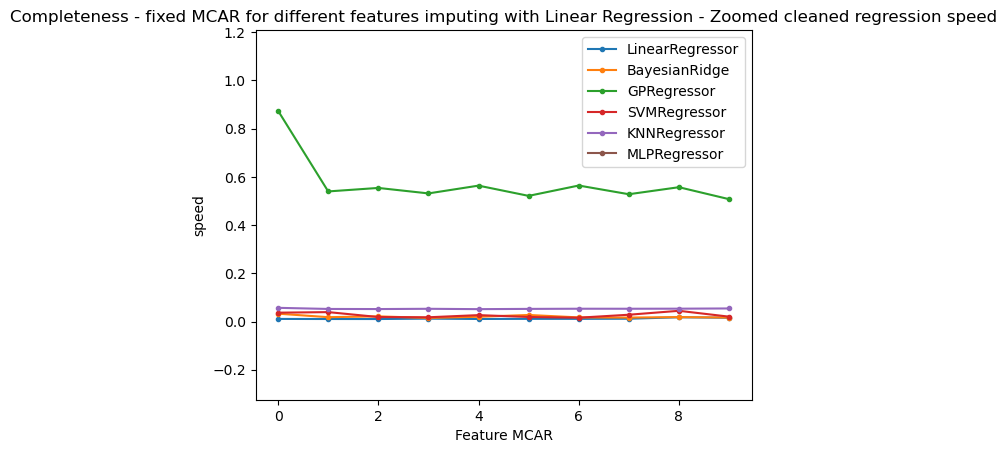

In [21]:
DESCRIPTION = 'Completeness - fixed MCAR for different features imputing with Linear Regression'
RESULTS_PER_ALGORITHM = []

IMPUTER = KNNImputer(n_neighbors=5)

for algorithm in REGRESSION_ALGORITHMS:  # FIRST CYCLE ON THE ALGORITHMS
    RESULTS_ALGORITHM = []

    for i in range(len(X_AXIS)):
        # DATA COLLECTION - creating 10 datasets with an increase in the samples
        X, y = make_dataset_for_regression(
            n_samples=1000, n_features=10, n_informative=10, n_targets=1, bias=0.0,
            effective_rank=None, tail_strength=0.5, noise=0.0, seed=2023
        )

        X = pd.DataFrame(X)

        pollute_data_mcar_for_one_feature(X, i, percent_incomplete=0.2)

        #Create a Linear Regression model to estimate the missing data
        model = linear_model.LinearRegression()

        #First extract one of the columns as target value, which will be the target of the current prediction. 
        # For the rest of the columns we will apply random imputation and will use them as the training dataset to feed to the Machine Learning algorithm, and obtain a prediction of the target column, in order to impute its missing values.
        target = X[i]
        training = X.drop(columns=[i])
        
        training = training[target.notnull()]
        target = target[target.notnull()]
        
        training = training.fillna(training.mean())
        model.fit(training, target)
        model_predicted = model.predict(training)
        
        X_CLEAN = X.copy()
        X_CLEAN[i].fillna(pd.Series(model_predicted))

        # DATA ANALYSIS
        RESULTS_ALGORITHM.append(regression(X_CLEAN, y, algorithm, SEED))

    RESULTS_PER_ALGORITHM.append(RESULTS_ALGORITHM)

plot_results(
    x_axis_values=X_AXIS, x_label=X_LABEL, results=RESULTS_PER_ALGORITHM, title=DESCRIPTION,
    algorithms=REGRESSION_ALGORITHMS, cleaned_data=True
)

## Experiment 4. Completeness - MCAR for each feature in an increasing dataset

In [ ]:
DESCRIPTION = 'Completeness - MCAR for each feature in an increasing dataset'
X_LABEL = "Number of samples"

RESULTS_PER_ALGORITHM = []
X_AXIS = [1000 + (n * 10) for n in range(1, 11)]

for algorithm in REGRESSION_ALGORITHMS:
    RESULTS_ALGORITHM = []

    for i in range(len(X_AXIS)):
        # DATA COLLECTION - creating 10 datasets with an increase in the samples
        X, y = make_dataset_for_regression(
            n_samples=1000 + (i * 10), n_features=5, n_informative=3, n_targets=1,
            bias=0.0, effective_rank=None, tail_strength=0.5, noise=0.0, seed=2023
        )

        X = pd.DataFrame(X)

        pollute_data_mcar_for_each_feature_in_incremental_way(X)

        # DATA ANALYSIS
        RESULTS_ALGORITHM.append(regression(X, y, algorithm, SEED))

    RESULTS_PER_ALGORITHM.append(RESULTS_ALGORITHM)

plot_results(
    x_axis_values=X_AXIS, x_label=X_LABEL, results=RESULTS_PER_ALGORITHM, title=DESCRIPTION,
    algorithms=REGRESSION_ALGORITHMS
)

In [ ]:
RESULTS_PER_ALGORITHM = []

SI = SimpleImputer(missing_values=np.NaN, strategy="median")  # as fillna - mean

for algorithm in REGRESSION_ALGORITHMS:
    RESULTS_ALGORITHM = []

    for i in range(len(X_AXIS)):
        # DATA COLLECTION - creating 10 datasets with an increase in the samples
        X, y = make_dataset_for_regression(
            n_samples=1000 + (i * 10), n_features=5, n_informative=3, n_targets=1,
            bias=0.0, effective_rank=None, tail_strength=0.5, noise=0.0, seed=2023
        )

        X = pd.DataFrame(X)

        pollute_data_mcar_for_each_feature_in_incremental_way(X)

        X_CLEAN = SI.fit_transform(X)

        # DATA ANALYSIS
        RESULTS_ALGORITHM.append(regression(X_CLEAN, y, algorithm, SEED))

    RESULTS_PER_ALGORITHM.append(RESULTS_ALGORITHM)

plot_results(
    x_axis_values=X_AXIS, x_label=X_LABEL, results=RESULTS_PER_ALGORITHM, title=DESCRIPTION,
    algorithms=REGRESSION_ALGORITHMS, cleaned_data=True
)

## Experiment 5: Completeness - Different percentages of values MAR

In [ ]:
DESCRIPTION = 'Completeness - Different percentages of values MAR'
X_LABEL = "Number of samples"

RESULTS_PER_ALGORITHM = []
X_AXIS = [1000 + (n * 10) for n in range(1, 11)]

for algorithm in REGRESSION_ALGORITHMS:
    RESULTS_ALGORITHM = []

    for i in range(len(X_AXIS)):
        # DATA COLLECTION - creating 10 datasets with an increase in the samples
        X, y = make_dataset_for_regression(
            n_samples=1000 + (i * 10), n_features=3, n_informative=3, n_targets=1,
            bias=0.0, effective_rank=None, tail_strength=0.5, noise=0.0, seed=2023
        )

        X = pd.DataFrame(X)

        pollute_data_mar(X, 1, 2)

        # DATA ANALYSIS
        RESULTS_ALGORITHM.append(regression(X, y, algorithm, SEED))

    RESULTS_PER_ALGORITHM.append(RESULTS_ALGORITHM)

plot_results(
    x_axis_values=X_AXIS, x_label=X_LABEL, results=RESULTS_PER_ALGORITHM, title=DESCRIPTION,
    algorithms=REGRESSION_ALGORITHMS
)

In [ ]:
RESULTS_PER_ALGORITHM = []

SI = SimpleImputer(missing_values=np.NaN, strategy="median")  # as fillna - mean

for algorithm in REGRESSION_ALGORITHMS:
    RESULTS_ALGORITHM = []

    for i in range(len(X_AXIS)):
        # DATA COLLECTION - creating 10 datasets with an increase in the samples
        X, y = make_dataset_for_regression(
            n_samples=1000 + (i * 10), n_features=3, n_informative=3, n_targets=1,
            bias=0.0, effective_rank=None, tail_strength=0.5, noise=0.0, seed=2023
        )

        X = pd.DataFrame(X)

        pollute_data_mar(X, 1, 2)

        X_CLEAN = SI.fit_transform(X)

        # DATA ANALYSIS
        RESULTS_ALGORITHM.append(regression(X_CLEAN, y, algorithm, SEED))

    RESULTS_PER_ALGORITHM.append(RESULTS_ALGORITHM)

plot_results(
    x_axis_values=X_AXIS, x_label=X_LABEL, results=RESULTS_PER_ALGORITHM, title=DESCRIPTION,
    algorithms=REGRESSION_ALGORITHMS, cleaned_data=True
)

## Experiment 6: Completeness - Different percentages of values MNAR

In [ ]:
DESCRIPTION = 'Completeness - Different percentages of values MNAR'
X_LABEL = "Number of samples"

RESULTS_PER_ALGORITHM = []
X_AXIS = [1000 + (n * 10) for n in range(1, 11)]

for algorithm in REGRESSION_ALGORITHMS:
    RESULTS_ALGORITHM = []

    for i in range(len(X_AXIS)):
        # DATA COLLECTION - creating 10 datasets with an increase in the samples
        X, y = make_dataset_for_regression(
            n_samples=1000 + (i * 10), n_features=3, n_informative=3, n_targets=1,
            bias=0.0, effective_rank=None, tail_strength=0.5, noise=0.0, seed=2023
        )

        X = pd.DataFrame(X)

        pollute_data_mnar(X, 1)

        # DATA ANALYSIS
        RESULTS_ALGORITHM.append(regression(X, y, algorithm, SEED))

    RESULTS_PER_ALGORITHM.append(RESULTS_ALGORITHM)

plot_results(
    x_axis_values=X_AXIS, x_label=X_LABEL, results=RESULTS_PER_ALGORITHM, title=DESCRIPTION,
    algorithms=REGRESSION_ALGORITHMS
)

In [ ]:
RESULTS_PER_ALGORITHM = []

SI = SimpleImputer(missing_values=np.NaN, strategy="median")  # as fillna - mean

for algorithm in REGRESSION_ALGORITHMS:
    RESULTS_ALGORITHM = []

    for i in range(len(X_AXIS)):
        # DATA COLLECTION - creating 10 datasets with an increase in the samples
        X, y = make_dataset_for_regression(
            n_samples=1000 + (i * 10), n_features=3, n_informative=3, n_targets=1,
            bias=0.0, effective_rank=None, tail_strength=0.5, noise=0.0, seed=2023
        )

        X = pd.DataFrame(X)

        pollute_data_mnar(X, 1)

        X_CLEAN = SI.fit_transform(X)

        # DATA ANALYSIS
        RESULTS_ALGORITHM.append(regression(X_CLEAN, y, algorithm, SEED))

    RESULTS_PER_ALGORITHM.append(RESULTS_ALGORITHM)

plot_results(
    x_axis_values=X_AXIS, x_label=X_LABEL, results=RESULTS_PER_ALGORITHM, title=DESCRIPTION,
    algorithms=REGRESSION_ALGORITHMS, cleaned_data=True
)

## Experiment 7: Completeness - Different percentages of values MCAR for the most informative features

In [ ]:
DESCRIPTION = 'Completeness - MCAR for the most informative features'
X_LABEL = "Percentage of missing values"

RESULTS_PER_ALGORITHM = []
X_AXIS = [n * 0.05 for n in range(1, 11)]

for algorithm in REGRESSION_ALGORITHMS:
    RESULTS_ALGORITHM = []

    for i in range(len(X_AXIS)):
        # DATA COLLECTION - creating 10 datasets with an increase in the samples
        X, y = make_dataset_for_regression(
            n_samples=1000, n_features=9, n_informative=4, n_targets=1,
            bias=0.0, effective_rank=None, tail_strength=0.5, noise=0.0, seed=2023
        )

        X = pd.DataFrame(X)

        X = pollute_most_important_features(X, y, percentage=X_AXIS[i])

        # DATA ANALYSIS
        RESULTS_ALGORITHM.append(regression(X, y, algorithm, SEED))

    RESULTS_PER_ALGORITHM.append(RESULTS_ALGORITHM)

plot_results(
    x_axis_values=X_AXIS, x_label=X_LABEL, results=RESULTS_PER_ALGORITHM, title=DESCRIPTION,
    algorithms=REGRESSION_ALGORITHMS
)

In [ ]:
RESULTS_PER_ALGORITHM = []

SI = SimpleImputer(missing_values=np.NaN, strategy="median")  # as fillna - mean

for algorithm in REGRESSION_ALGORITHMS:
    RESULTS_ALGORITHM = []

    for i in range(len(X_AXIS)):
        # DATA COLLECTION - creating 10 datasets with an increase in the samples
        X, y = make_dataset_for_regression(
            n_samples=1000, n_features=9, n_informative=4, n_targets=1,
            bias=0.0, effective_rank=None, tail_strength=0.5, noise=0.0, seed=2023
        )

        X = pd.DataFrame(X)

        X = pollute_most_important_features(X, y, percentage=X_AXIS[i])

        X_CLEAN = SI.fit_transform(X)

        # DATA ANALYSIS
        RESULTS_ALGORITHM.append(regression(X_CLEAN, y, algorithm, SEED))

    RESULTS_PER_ALGORITHM.append(RESULTS_ALGORITHM)

plot_results(
    x_axis_values=X_AXIS, x_label=X_LABEL, results=RESULTS_PER_ALGORITHM, title=DESCRIPTION,
    algorithms=REGRESSION_ALGORITHMS, cleaned_data=True
)

## Experiment 8: Different percentages of values MCAR for the less informative features

In [ ]:
DESCRIPTION = 'Completeness - MCAR for the less informative features'
X_LABEL = "Percentage of missing values"

RESULTS_PER_ALGORITHM = []
X_AXIS = [n * 0.05 for n in range(1, 11)]

for algorithm in REGRESSION_ALGORITHMS:
    RESULTS_ALGORITHM = []

    for i in range(len(X_AXIS)):
        # DATA COLLECTION - creating 10 datasets with an increase in the samples
        X, y = make_dataset_for_regression(
            n_samples=1000, n_features=9, n_informative=4, n_targets=1,
            bias=0.0, effective_rank=None, tail_strength=0.5, noise=0.0, seed=2023
        )

        X = pd.DataFrame(X)

        X = pollute_less_important_features(X, y, percentage=X_AXIS[i])

        # DATA ANALYSIS
        RESULTS_ALGORITHM.append(regression(X, y, algorithm, SEED))

    RESULTS_PER_ALGORITHM.append(RESULTS_ALGORITHM)

plot_results(
    x_axis_values=X_AXIS, x_label=X_LABEL, results=RESULTS_PER_ALGORITHM, title=DESCRIPTION,
    algorithms=REGRESSION_ALGORITHMS
)

In [ ]:
RESULTS_PER_ALGORITHM = []

SI = SimpleImputer(missing_values=np.NaN, strategy="median")  # as fillna - mean

for algorithm in REGRESSION_ALGORITHMS:
    RESULTS_ALGORITHM = []

    for i in range(len(X_AXIS)):
        # DATA COLLECTION - creating 10 datasets with an increase in the samples
        X, y = make_dataset_for_regression(
            n_samples=1000, n_features=9, n_informative=4, n_targets=1,
            bias=0.0, effective_rank=None, tail_strength=0.5, noise=0.0, seed=2023
        )

        X = pd.DataFrame(X)

        X = pollute_less_important_features(X, y, percentage=X_AXIS[i])

        X_CLEAN = SI.fit_transform(X)

        # DATA ANALYSIS
        RESULTS_ALGORITHM.append(regression(X_CLEAN, y, algorithm, SEED))

    RESULTS_PER_ALGORITHM.append(RESULTS_ALGORITHM)

plot_results(
    x_axis_values=X_AXIS, x_label=X_LABEL, results=RESULTS_PER_ALGORITHM, title=DESCRIPTION,
    algorithms=REGRESSION_ALGORITHMS, cleaned_data=True
)

## Experiment 9: Completeness - Different percentages of values MNAR mixing informative and non informative values

## Experiment 10: Completeness - Different percentages combination of values MCAR and MNAR

# DISTINCTNESS

## Experiment 1: Distinctness - Mid-high distinctness

In [ ]:
DESCRIPTION = 'Distinctness - Mid-high distinctness'
X_LABEL = "Percentage of not distinct values"

RESULTS_PER_ALGORITHM = []
X_AXIS = [n * 0.05 for n in range(0, 11)]

for algorithm in REGRESSION_ALGORITHMS:
    RESULTS_ALGORITHM = []

    for i in range(len(X_AXIS)):
        # DATA COLLECTION - creating 10 datasets with an increase in the samples
        X, y = make_dataset_for_regression(
            n_samples=1000, n_features=3, n_informative=3, n_targets=1,
            bias=0.0, effective_rank=None, tail_strength=0.5, noise=0.0, seed=2023
        )

        X = pd.DataFrame(X)

        X = pollute_data_with_constant_feature(X, X_AXIS[i])

        # DATA ANALYSIS
        RESULTS_ALGORITHM.append(regression(X, y, algorithm, SEED))

    RESULTS_PER_ALGORITHM.append(RESULTS_ALGORITHM)

plot_results(
    x_axis_values=X_AXIS, x_label=X_LABEL, results=RESULTS_PER_ALGORITHM, title=DESCRIPTION,
    algorithms=REGRESSION_ALGORITHMS
)

## Experiment 2: Distinctness - Mid-low distinctness

In [ ]:
DESCRIPTION = 'Distinctness - Mid-low distinctness'
X_LABEL = "Percentage of not distinct values"

RESULTS_PER_ALGORITHM = []
X_AXIS = [n * 0.05 for n in range(10, 21)]

for algorithm in REGRESSION_ALGORITHMS:
    RESULTS_ALGORITHM = []

    for i in range(len(X_AXIS)):
        # DATA COLLECTION - creating 10 datasets with an increase in the samples
        X, y = make_dataset_for_regression(
            n_samples=1000, n_features=3, n_informative=3, n_targets=1,
            bias=0.0, effective_rank=None, tail_strength=0.5, noise=0.0, seed=2023
        )

        X = pd.DataFrame(X)

        X = pollute_data_with_constant_feature(X, X_AXIS[i])

        # DATA ANALYSIS
        RESULTS_ALGORITHM.append(regression(X, y, algorithm, SEED))

    RESULTS_PER_ALGORITHM.append(RESULTS_ALGORITHM)

plot_results(
    x_axis_values=X_AXIS, x_label=X_LABEL, results=RESULTS_PER_ALGORITHM, title=DESCRIPTION,
    algorithms=REGRESSION_ALGORITHMS
)

## Experiment 3: Distinctness - Different percentages among features

In [ ]:
DESCRIPTION = 'Distinctness - Different percentages among features'
X_LABEL = "Percentage of not distinct values"

RESULTS_PER_ALGORITHM = []
X_AXIS = [n * 0.05 for n in range(1, 11)]

for algorithm in REGRESSION_ALGORITHMS:
    RESULTS_ALGORITHM = []

    for i in range(len(X_AXIS)):
        # DATA COLLECTION - creating 10 datasets with an increase in the samples
        X, y = make_dataset_for_regression(
            n_samples=1000, n_features=9, n_informative=4, n_targets=1,
            bias=0.0, effective_rank=None, tail_strength=0.5, noise=0.0, seed=2023
        )

        X = pd.DataFrame(X)

        X = pollute_data_for_distinctness_issues_among_different_features(X, X_AXIS[i])

        # DATA ANALYSIS
        RESULTS_ALGORITHM.append(regression(X, y, algorithm, SEED))

    RESULTS_PER_ALGORITHM.append(RESULTS_ALGORITHM)

plot_results(
    x_axis_values=X_AXIS, x_label=X_LABEL, results=RESULTS_PER_ALGORITHM, title=DESCRIPTION,
    algorithms=REGRESSION_ALGORITHMS
)

## Experiment 4 - Distinctness - Random noise

In [ ]:
DESCRIPTION = 'Distinctness - Random noise'
X_LABEL = "Percentage of not distinct values"

RESULTS_PER_ALGORITHM = []
X_AXIS = [n * 0.00625 for n in range(1, 11)]

for algorithm in REGRESSION_ALGORITHMS:
    RESULTS_ALGORITHM = []

    for i in range(len(X_AXIS)):
        # DATA COLLECTION - creating 10 datasets with an increase in the samples
        X, y = make_dataset_for_regression(
            n_samples=1000, n_features=3, n_informative=3, n_targets=1,
            bias=0.0, effective_rank=None, tail_strength=0.5, noise=0.0, seed=2023
        )

        X = pd.DataFrame(X)

        X = pollute_data_with_random_noise(X, X_AXIS[i])

        # DATA ANALYSIS
        RESULTS_ALGORITHM.append(regression(X, y, algorithm, SEED))

    RESULTS_PER_ALGORITHM.append(RESULTS_ALGORITHM)

plot_results(
    x_axis_values=X_AXIS, x_label=X_LABEL, results=RESULTS_PER_ALGORITHM, title=DESCRIPTION,
    algorithms=REGRESSION_ALGORITHMS
)

## Experiment 5 - Distinctness - Categorical variables

In [ ]:
DESCRIPTION = 'Distinctness - Categorical variables'
X_LABEL = "Number of categorical variables"

RESULTS_PER_ALGORITHM = []
X_AXIS = [n for n in range(1, 11)]

for algorithm in REGRESSION_ALGORITHMS:
    RESULTS_ALGORITHM = []

    for i in range(len(X_AXIS)):
        # DATA COLLECTION - creating 10 datasets with an increase in the samples
        X, y = make_dataset_for_regression(
            n_samples=1000, n_features=9, n_informative=4, n_targets=1,
            bias=0.0, effective_rank=None, tail_strength=0.5, noise=0.0, seed=2023
        )

        X = pd.DataFrame(X)

        X = pollute_data_with_categorical_variables(X, X_AXIS[i])

        # DATA ANALYSIS
        RESULTS_ALGORITHM.append(regression(X, y, algorithm, SEED))

    RESULTS_PER_ALGORITHM.append(RESULTS_ALGORITHM)

plot_results(
    x_axis_values=X_AXIS, x_label=X_LABEL, results=RESULTS_PER_ALGORITHM, title=DESCRIPTION,
    algorithms=REGRESSION_ALGORITHMS
)

## Experiment 6 - Distinctness - Outliers

In [ ]:
DESCRIPTION = 'Distinctness - Outliers'
X_LABEL = "Percentage of outliers"

RESULTS_PER_ALGORITHM = []
X_AXIS = [n * 0.0125 for n in range(1, 11)]

for algorithm in REGRESSION_ALGORITHMS:
    RESULTS_ALGORITHM = []

    for i in range(len(X_AXIS)):
        # DATA COLLECTION - creating 10 datasets with an increase in the samples
        X, y = make_dataset_for_regression(
            n_samples=1000, n_features=9, n_informative=4, n_targets=1,
            bias=0.0, effective_rank=None, tail_strength=0.5, noise=0.0, seed=2023
        )

        X = pd.DataFrame(X)

        X = pollute_data_with_outliers(X, X_AXIS[i])

        # DATA ANALYSIS
        RESULTS_ALGORITHM.append(regression(X, y, algorithm, SEED))

    RESULTS_PER_ALGORITHM.append(RESULTS_ALGORITHM)

plot_results(
    x_axis_values=X_AXIS, x_label=X_LABEL, results=RESULTS_PER_ALGORITHM, title=DESCRIPTION,
    algorithms=REGRESSION_ALGORITHMS
)

In [ ]:
for filename in os.listdir('./Plot'):
    if 'Completeness' in filename and filename.endswith('.pdf'):
        if not os.path.exists('./Plot/completeness/'):
            os.mkdir('./Plot/completeness/')
        shutil.move(f'./Plot/{filename}', f'./Plot/completeness/{filename}')
    if 'Distinctness' in filename and filename.endswith('.pdf'):
        if not os.path.exists('./Plot/distinctness/'):
            os.mkdir('./Plot/distinctness/')
        shutil.move(f'./Plot/{filename}', f'./Plot/distinctness/{filename}')